In [106]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import xarray as xr
import xgboost as xgb
import seaborn as sns
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from statsmodels.tsa.vector_ar.dynamic import DynamicPanelVAR
%run ../src/models/geo_helpers.py
%run ../src/models/section_series.py
%load_ext rpy2.ipython
%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [95]:
city_locations_path = '../data/external/' +\
    'worldcitiespop.txt'

city_locations = pd.read_csv(city_locations_path, encoding = "ISO-8859-1").rename(columns={'City': 'city'})
city_locations = city_locations[city_locations['Population'] > 0] # filter for populated cities
print('Shape: {}'.format(city_locations.shape))
city_locations.head()

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape: (47980, 7)


,Country,city,AccentCity,Region,Population,Latitude,Longitude
6,ad,andorra la vella,Andorra la Vella,7.0000,"20,430.0000",42.5000,1.5167
20,ad,canillo,Canillo,2.0000,"3,292.0000",42.5667,1.6000
32,ad,encamp,Encamp,3.0000,"11,224.0000",42.5333,1.5833
49,ad,la massana,La Massana,4.0000,"7,211.0000",42.5500,1.5167
53,ad,les escaldes,Les Escaldes,8.0000,"15,854.0000",42.5000,1.5333


In [142]:
earthquake_locations_path = '../data/external/' +\
    'earthquakes_affected_locations/earthquakes_affected_locations.csv'

earthquake_locations = pd.read_csv(earthquake_locations_path, encoding = "ISO-8859-1")
earthquake_locations['city'] = earthquake_locations['city'].apply(lambda c: c.lower())
earthquake_locations['country'] = earthquake_locations['country'].apply(lambda c: c.lower())
print('Shape: {}'.format(earthquake_locations.shape))
earthquake_locations.head()

Shape: (2719, 13)


,id,country,city,latitude,longitude,geoname,year,month,day,Totaldeaths,Totalaffected,Totaldamage000US,insured_losses
0,1,afghanistan,takhar,36.7000,69.8000,NaN,1992,5,20,14,0,0,0
1,2,afghanistan,jowzan,36.7500,66.0000,Jowzjan,1994,5,1,160,100330,0,0
2,2,afghanistan,mazar-i-sharif,36.7500,67.0000,mazar-i-sharif,1994,5,1,160,100330,0,0
3,2,afghanistan,balkh,36.7501,66.8997,balkh,1994,5,1,160,100330,0,0
4,2,afghanistan,termez,37.2242,67.2783,NaN,1994,5,1,160,100330,0,0


In [153]:
class_path = '../data/external/' +\
    'class.csv'
world_bank_class = pd.read_csv(class_path, encoding = "ISO-8859-1", skiprows=[1]).drop(['Unnamed: {}'.format(i) for i in [0,1,4]], axis=1)\
    .rename(columns={'Economy': 'country'})

world_bank_class['country'] = world_bank_class['country'].apply(lambda c: str(c).lower())
world_bank_class.head()

,country,Code,Region,Income group,Lending category,Other
0,afghanistan,AFG,South Asia,Low income,IDA,HIPC
1,albania,ALB,Europe & Central Asia,Upper middle income,IBRD,NaN
2,algeria,DZA,Middle East & North Africa,Upper middle income,IBRD,NaN
3,american samoa,ASM,East Asia & Pacific,Upper middle income,..,NaN
4,andorra,AND,Europe & Central Asia,High income,..,NaN


In [198]:
class_path = '../data/external/' +\
    'inflation.csv'
inflation = pd.read_csv(class_path, encoding = "ISO-8859-1", skiprows=[1]).rename(columns={'Country Name': 'country'})\
    .drop(['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 61'], axis=1).set_index('country').fillna(0)

inflation = inflation[[c for c in inflation.columns if int(c) > 1992 & int(c) < 2014]].reset_index()
inflation = pd.melt(inflation, id_vars=['country'], value_vars=[str(y) for y in range(1993,2014)])\
    .rename(columns={'variable': 'year', 'value': 'inflation'})
inflation['country'] = inflation['country'].apply(lambda c: str(c).lower())
inflation.head()

,country,year,inflation
0,afghanistan,1993,0.0000
1,angola,1993,"1,379.4143"
2,albania,1993,85.0048
3,andorra,1993,0.0000
4,arab world,1993,9.3703


In [199]:
%run ../src/models/section_series.py
annual_frames = {}
for year in range(1992, 1993):
    print('Loading data for year {}'.format(year))
    try:
#         annual_frames[year] = pd.read_csv('../data/processed/section_series_small/{}.csv'.format(year)).set_index('city')
        raise FileNotFoundError()
    except FileNotFoundError:
        earthquake_locations_in_year = earthquake_locations[earthquake_locations.year == year]
        earthquake_cities_in_year = earthquake_locations_in_year['city'].unique()
        annual_frames[year] = pd.merge(city_locations, earthquake_locations_in_year, on='city', how='left')
        annual_frames[year] = annual_frames[year].fillna(0).reset_index().groupby('city').agg({
            'Totaldeaths': 'sum',
            'Totalaffected': 'sum',
            'Totaldamage000US': 'sum',
            'insured_losses': 'sum',
            'Latitude': 'first',
            'Longitude': 'first',
            'country': 'first',
            'city': 'first'
        }).set_index('city').rename(columns={
            'Latitude': 'latitude',
            'Longitude': 'longitude',
            'Totaldeaths': 'total_deaths',
            'Totalaffected': 'total_affected',
            'Totaldamage000US': 'total_damage_usd'
        })
        print(annual_frames[year].columns)
        print(world_bank_class.columns)
        annual_frames[year] = annual_frames[year].merge(world_bank_class)
        annual_frames[year] = annual_frames[year].merge(inflation)
        annual_frames[year]['year'] = year
        annual_frames[year]['earthquake_dummy'] = annual_frames[year].index.map(lambda c: c in earthquake_cities_in_year)
        series_loader = SectionSeriesLoader(
            img_shape=(200, 200),
            start_year=year,
            end_year=year,
            SRC_PATH='../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/*.npz')
        target_coords_list = [{'lat': r[0],'lng': r[1]} for r
            in annual_frames[year][['latitude', 'longitude']].values]
        annual_frames[year]['mean_luminosity_return'] = series_loader.load_multiple_means(target_coords_list).reshape(-1)
        annual_frames[year].to_csv('../data/processed/section_series_small/{}.csv'.format(year))
        
    print(annual_frames[year].shape)
    
panel = xr.Dataset.from_dataframe(pd.concat(annual_frames))
# del annual_frames

Loading data for year 1992
Index(['total_deaths', 'latitude', 'total_affected', 'longitude',
       'insured_losses', 'country', 'total_damage_usd'],
      dtype='object')
Index(['country', 'Code', 'Region', 'Income group', 'Lending category',
       'Other'],
      dtype='object')
['../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F101992.v4b_web.stable_lights.avg_vis.tif.npz']
Loading file ../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F101992.v4b_web.stable_lights.avg_vis.tif.npz
(357, 16)


In [157]:
panel

<xarray.Dataset>
Dimensions:                 (level_0: 1, level_1: 17)
Coordinates:
  * level_0                 (level_0) int64 1992
  * level_1                 (level_1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
Data variables:
    total_deaths            (level_0, level_1) float64 33.0 11.0 11.0 1.0 ...
    latitude                (level_0, level_1) float64 20.43 6.985 6.579 ...
    total_affected          (level_0, level_1) float64 4.905e+03 1.635e+03 ...
    longitude               (level_0, level_1) float64 -103.7 -76.75 -76.89 ...
    insured_losses          (level_0, level_1) float64 0.0 0.0 0.0 0.0 0.0 ...
    country                 (level_0, level_1) object 'colombia' 'colombia' ...
    total_damage_usd        (level_0, level_1) float64 0.0 0.0 0.0 5e+04 ...
    Code                    (level_0, level_1) object 'COL' 'COL' 'COL' ...
    Region                  (level_0, level_1) object 'Latin America & Caribbean' ...
    Income group            (level_0, level_1) object 'Uppe

In [156]:
panel.sel(city='port-au-prince').to_dataframe()

ValueError: dimensions or multi-index levels ['city'] do not exist

In [114]:
port_au_prince = panel.sel(city='port-au-prince').to_dataframe()
port_au_prince.head()

,city,total_deaths,latitude,total_affected,longitude,insured_losses,total_damage_usd,year,earthquake_dummy,mean_luminosity_return
level_0,,,,,,,,,,
1992,port-au-prince,0.0000,18.5392,0.0000,-72.3350,0.0000,0.0000,1992,False,0.2728
1993,port-au-prince,0.0000,18.5392,0.0000,-72.3350,0.0000,0.0000,1993,False,0.2717
1994,port-au-prince,0.0000,18.5392,0.0000,-72.3350,0.0000,0.0000,1994,False,0.2742
1995,port-au-prince,0.0000,18.5392,0.0000,-72.3350,0.0000,0.0000,1995,False,0.4103
1996,port-au-prince,0.0000,18.5392,0.0000,-72.3350,0.0000,0.0000,1996,False,0.4128


In [116]:
%%R
install.packages('dynlm')

/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/3.3/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: trying URL 'https://mirror.lzu.edu.cn/CRAN/src/contrib/dynlm_0.3-5.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Content type 'application/octet-stream'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  length 17807 bytes (17 KB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib

In [115]:
%%R -i port_au_prince
data <- port_au_prince[c('insured_losses', 'total_affected', 'earthquake_dummy', 'mean_luminosity_return')]
require('dynlm')
data$earthquake_dummy <- as.numeric(data$earthquake_dummy)
logged_data <- data.matrix(log10(data))
# dfm <- dynlm(data ~ L(data, 1) + L(data, 2))
# # print(dfm)
print(logged_data)

     insured_losses total_affected earthquake_dummy mean_luminosity_return
1992           -Inf           -Inf             -Inf           -0.564195436
1993           -Inf           -Inf             -Inf           -0.565990291
1994           -Inf           -Inf             -Inf           -0.561932550
1995           -Inf           -Inf             -Inf           -0.386872022
1996           -Inf           -Inf             -Inf           -0.384234010
1997           -Inf           -Inf             -Inf           -0.506751130
1998           -Inf           -Inf             -Inf           -0.486582617
1999           -Inf           -Inf             -Inf           -0.466037392
2000           -Inf           -Inf             -Inf           -0.490159278
2001           -Inf           -Inf             -Inf           -0.367795867
2002           -Inf           -Inf             -Inf           -0.482606141
2003           -Inf           -Inf             -Inf           -0.596579181
2004           -Inf      

In [37]:
pred = linear_tree_booster.predict(test_data)
test_ae = test_data.get_label() - pred
test_wae = (test_data.get_label() - pred) * test_data.get_label()
test_mse = mean_squared_error(test_data.get_label(), pred)
true_mean = test_data.get_label().mean()

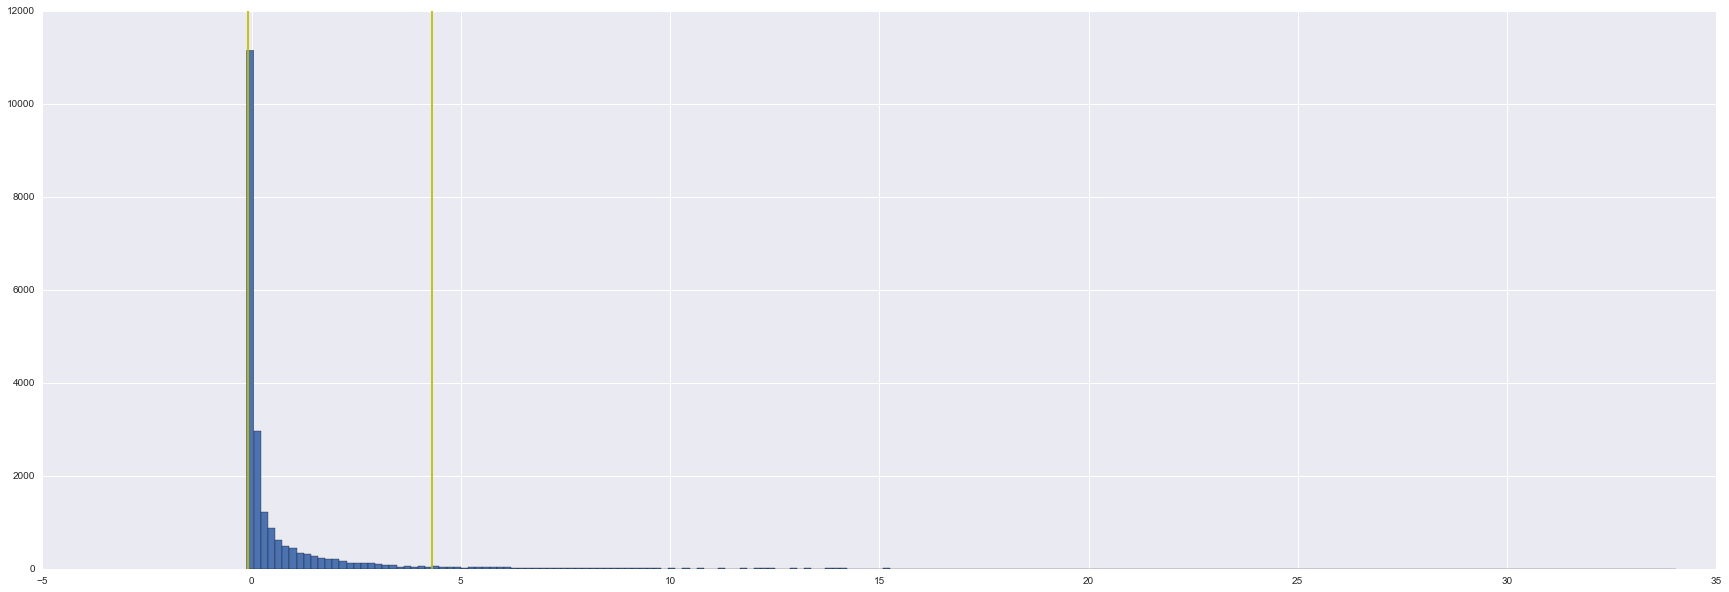

In [38]:
plt.figure(figsize=(30,10))
plt.hist(test_wae, bins=200)
plt.axvline(x=np.percentile(test_wae, 95), c='y')
plt.axvline(x=np.percentile(test_wae, 5), c='y')
plt.show()

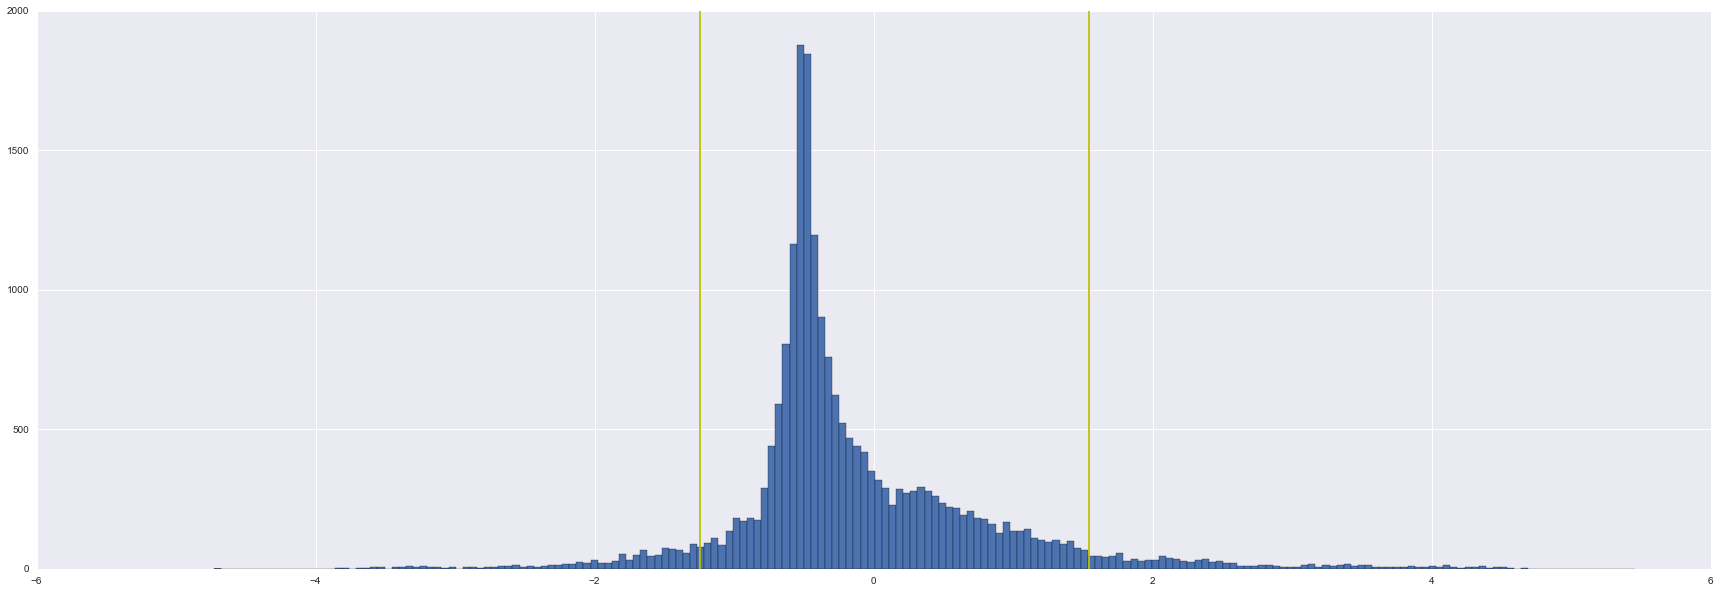

In [41]:
plt.figure(figsize=(30,10))
plt.hist(test_ae, bins=200)
plt.axvline(x=np.percentile(test_ae, 95), c='y')
plt.axvline(x=np.percentile(test_ae, 5), c='y')
plt.show()

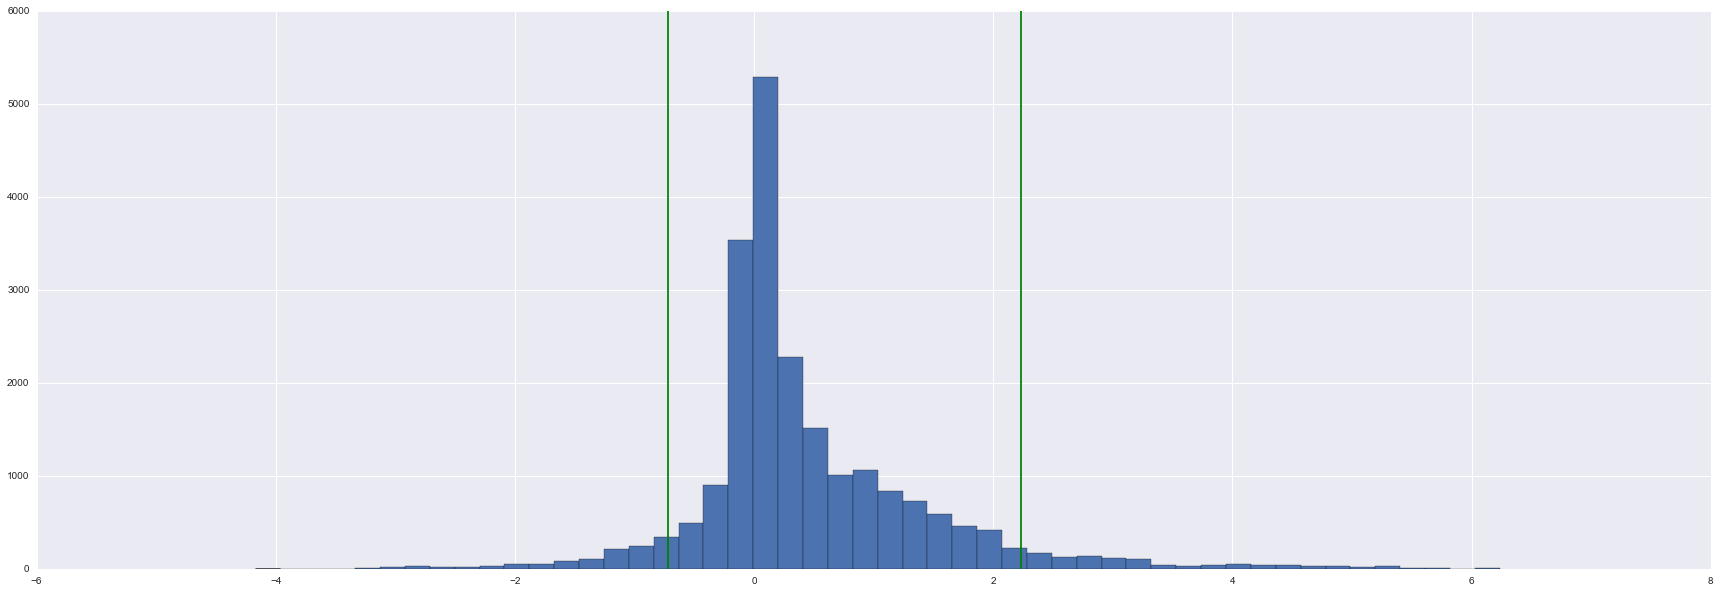

In [42]:
plt.figure(figsize=(30,10))
plt.hist(test_data.get_label(), bins=50)
plt.axvline(x=np.percentile(test_data.get_label(), 95), c='g')
plt.axvline(x=np.percentile(test_data.get_label(), 5), c='g')
plt.show()

ValueError: Booster.get_score() results in empty

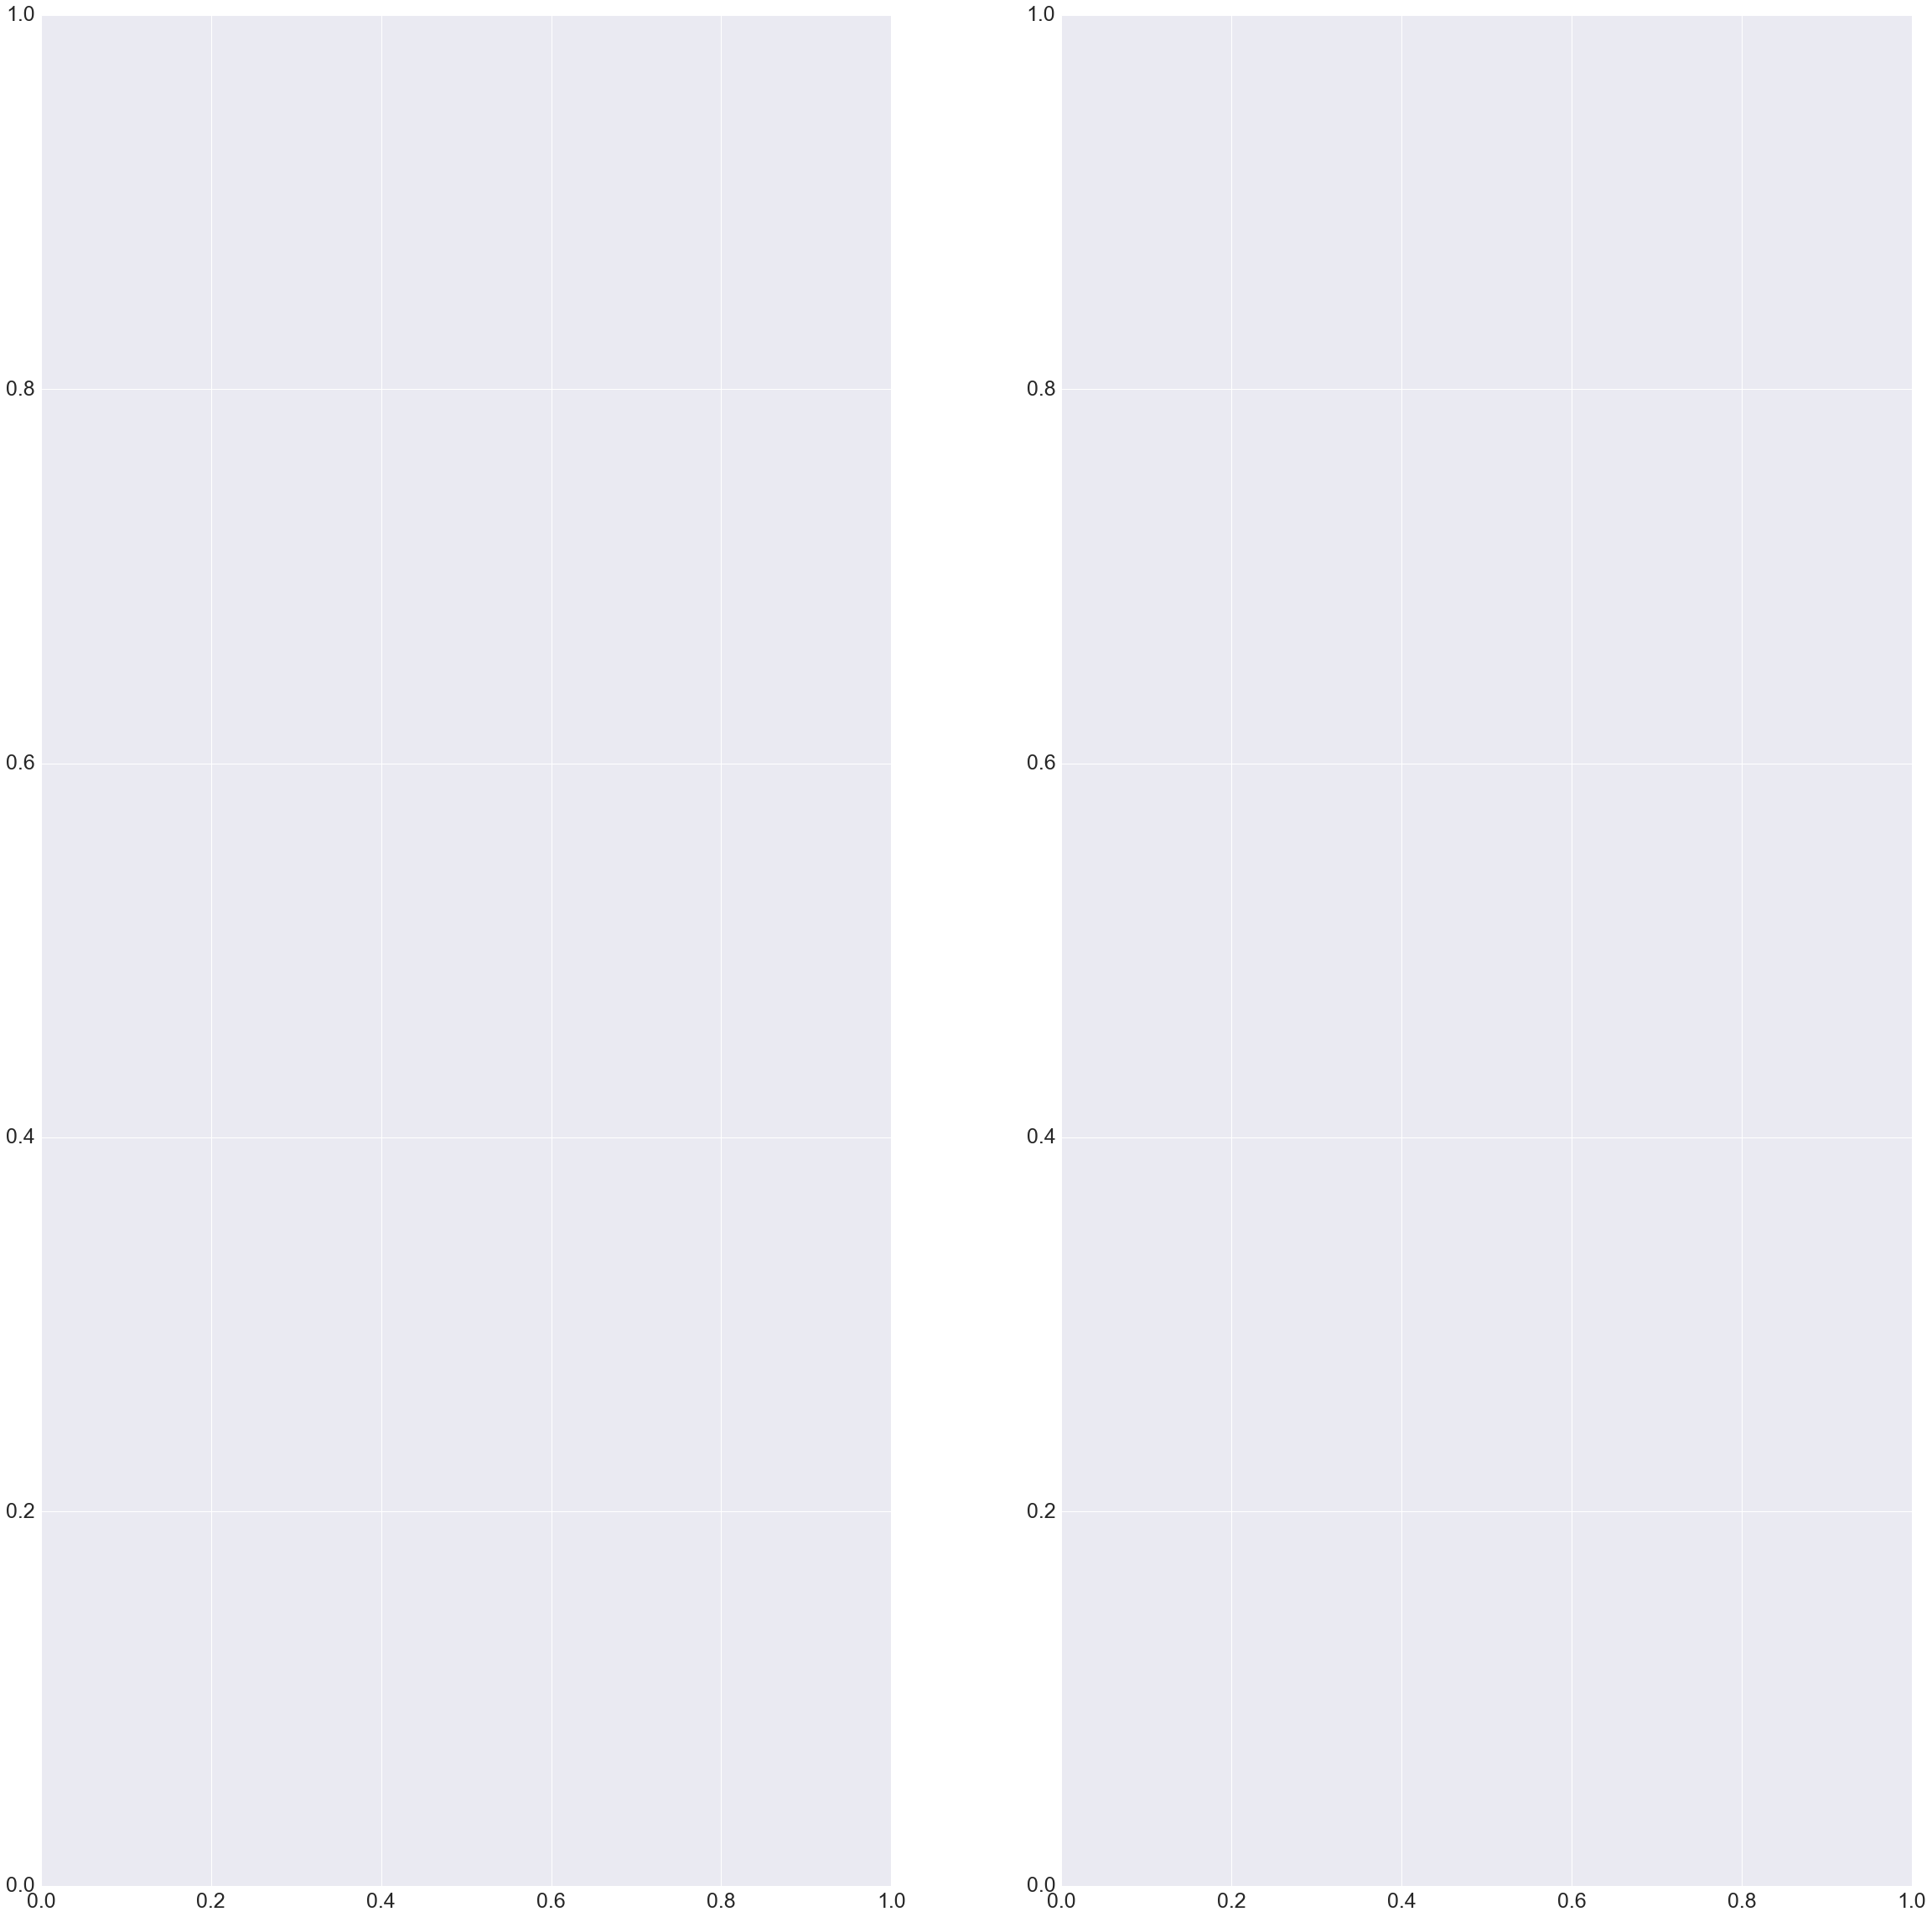

In [44]:
mpl.rc('xtick', labelsize=25) 
mpl.rc('ytick', labelsize=25) 
fig, axs = plt.subplots(1,2,figsize=(40,40))
xgb.plot_importance(linear_tree_booster, height=.4, importance_type='weight', ax=axs[1])
plt.show()

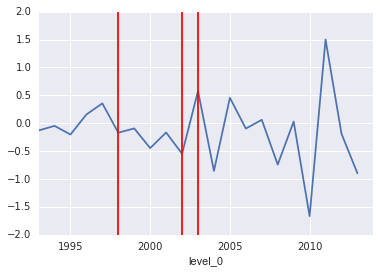

In [316]:
df = panel.sel(city='takhar').to_dataframe()
df['mean_luminosity_return'].plot()
for i, row in df[df['earthquake_dummy'] == True].iterrows():
    plt.axvline(x=row.year, c='r')

In [406]:
city_df = panel.sel(city='takhar')\
    .to_dataframe()[['latitude',
                     'longitude',
                     'mean_luminosity_return',
                     'total_affected',
                     'total_damage_usd',
                     'insured_losses',
                     'total_deaths',
                     'earthquake_dummy']].reset_index()
feature = city_df[(city_df.level_0 <= 2012) & (city_df.level_0 > 1994)].drop('level_0', axis=1).values.reshape(-1)
target = city_df[city_df.level_0 == 2013]['mean_luminosity_return'].mean()
# print('True: {}, Predicted: {}'.format(target,linear_tree_booster.predict(xgb.DMatrix(feature.reshape(1,-1)))))

In [409]:
city_df

,level_0,latitude,longitude,mean_luminosity_return,total_affected,total_damage_usd,insured_losses,total_deaths,earthquake_dummy
0,1993,47.56,124.22,-0.13,0.00,0.00,0.00,0.00,False
1,1994,47.56,124.22,-0.05,0.00,0.00,0.00,0.00,False
2,1995,47.56,124.22,-0.20,0.00,0.00,0.00,0.00,False
3,1996,47.56,124.22,0.16,0.00,0.00,0.00,0.00,False
4,1997,47.56,124.22,0.36,0.00,0.00,0.00,0.00,False
5,1998,47.56,124.22,-0.17,"32,818.00","10,000.00",0.00,"2,323.00",True
6,1999,47.56,124.22,-0.09,0.00,0.00,0.00,0.00,False
7,2000,47.56,124.22,-0.45,0.00,0.00,0.00,0.00,False
8,2001,47.56,124.22,-0.17,0.00,0.00,0.00,0.00,False
9,2002,47.56,124.22,-0.55,"3,513.00",0.00,0.00,150.00,True
